In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
countries= gpd.read_file(r"data\countries.geojson")
clean_elections=pd.read_csv(r"data\clean_elections.csv")
unemployment=pd.read_csv(r"data\unemployment.csv")
gdpcapita=pd.read_csv(r"data\gdp_percapita.csv")
population=pd.read_csv(r"data\population.csv")
gini_index=pd.read_csv(r"data\gini_index.csv")
destination_ref=pd.read_csv(r"data\destination_refugees.csv")
origin_ref=pd.read_csv(r"data\origin_refugees.csv")

In [3]:
year='2019'
temp=unemployment.loc[unemployment['Indicator Id']==3296, [year,'Country ISO3']]
temp.rename({year:'unemployment', 'Country ISO3':'ISO_A3'}, axis=1, inplace=True)
result=pd.merge(countries,temp,how='left', on='ISO_A3')
temp=clean_elections.loc[clean_elections['Indicator Id']==41828, ['Country ISO3',year]]
temp.rename({year:'clean_elections', 'Country ISO3':'ISO_A3'}, axis=1, inplace=True)
result=pd.merge(result,temp,how='left', on='ISO_A3')
temp=gdpcapita.loc[:,['Country Code',year]]
temp.rename({year:'gdp_capita', 'Country Code':'ISO_A3'}, axis=1, inplace=True)
result=pd.merge(result,temp,how='left', on='ISO_A3')
temp=population.loc[:,['Country Code',year]]
temp.rename({year:'population', 'Country Code':'ISO_A3'}, axis=1, inplace=True)
result=pd.merge(result,temp,how='left', on='ISO_A3')
temp=gini_index.loc[:,['Country Code',year]]
temp.rename({year:'gini_index', 'Country Code':'ISO_A3'}, axis=1, inplace=True)
result=pd.merge(result,temp,how='left', on='ISO_A3')
temp=destination_ref.loc[:,pd.concat([pd.Series(['Country Code']), pd.Series(range(int(year)-5,int(year)+1)).astype(str)])]
temp['avg_inc_ref_5y'] = temp[pd.Series(range(int(year)-5,int(year))).astype(str)].sum(axis=1)/5
temp['ratio_inc_ref_5y'] = temp[str(int(year)-1)]/temp[str(int(year)-5)]
temp.rename({year:'incomming_ref', 'Country Code':'ISO_A3'}, axis=1, inplace=True)
result=pd.merge(result,temp.loc[:,['ISO_A3', 'incomming_ref', 'avg_inc_ref_5y', 'ratio_inc_ref_5y']],how='left', on='ISO_A3')
result

,ADMIN,ISO_A3,geometry,unemployment,clean_elections,gdp_capita,population,gini_index,incomming_ref,avg_inc_ref_5y,ratio_inc_ref_5y
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",5.1,NaN,NaN,106310.0,NaN,NaN,0.0,NaN
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",NaN,0.436665,494.179350,38041757.0,NaN,72227.0,153179.8,0.240423
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",NaN,0.429435,2809.626088,31825299.0,NaN,25793.0,25507.4,2.576674
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993...",11.5,0.590648,5395.659532,2854191.0,NaN,120.0,123.4,1.189189
...,...,...,...,...,...,...,...,...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564...",NaN,NaN,4322.868457,197093.0,NaN,NaN,3.0,NaN
251,Yemen,YEM,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12...",NaN,0.003942,NaN,29161922.0,NaN,268503.0,265970.0,1.026091
252,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -...",28.7,0.685381,6624.761865,58558267.0,NaN,78395.0,100562.8,0.795894
253,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619...",NaN,0.426945,1305.001031,17861034.0,NaN,57518.0,34496.2,1.950911


<AxesSubplot:>

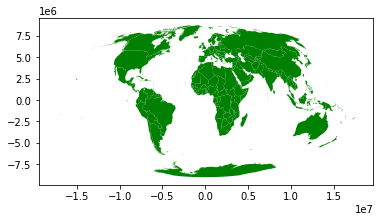

In [4]:
countries_geom = result.geometry.to_crs("ESRI:54009")
fig, ax = plt.subplots(ncols=1, nrows=1)
countries_geom.plot(ax=ax, color='green', zorder=1)

In [5]:
countries_buffer = countries_geom.buffer(200000)

In [6]:
# add NEIGHBORS column
result["neighbors"] = None  

for index, country in result.iterrows():   

    # get 'not disjoint' countries
    neighbors = result[~result.geometry.disjoint(country.geometry)].ISO_A3.tolist()

    # remove own name of the country from the list
    neighbors = [ name for name in neighbors if country.ISO_A3 != name ]

    # add names of neighbors as NEIGHBORS value
    result.at[index, "neighbors"] = ", ".join(neighbors)

In [7]:
sum_out_ref_neighbors = []
temp = origin_ref.loc[:,['Country Code', str(int(year)-1)]]
for country in result.ISO_A3:
    neigh_ref = temp[temp["Country Code"].isin([x.strip(' ') for x in result[result.ISO_A3 == country].neighbors.str.split(',').reset_index(drop=True)[0]])]
    sum_out_ref_neighbors.append(neigh_ref[str(int(year)-1)].sum())

In [8]:
result['outgoing_ref_neighbors'] = sum_out_ref_neighbors

In [9]:
result

,ADMIN,ISO_A3,geometry,unemployment,clean_elections,gdp_capita,population,gini_index,incomming_ref,avg_inc_ref_5y,ratio_inc_ref_5y,neighbors,outgoing_ref_neighbors
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",5.1,NaN,NaN,106310.0,NaN,NaN,0.0,NaN,,0.0
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",NaN,0.436665,494.179350,38041757.0,NaN,72227.0,153179.8,0.240423,"CHN, IRN, PAK, TJK, TKM, UZB",479657.0
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",NaN,0.429435,2809.626088,31825299.0,NaN,25793.0,25507.4,2.576674,"COD, COG, NAM, ZMB",735253.0
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.0
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993...",11.5,0.590648,5395.659532,2854191.0,NaN,120.0,123.4,1.189189,"GRC, -99, MKD, MNE",2543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564...",NaN,NaN,4322.868457,197093.0,NaN,NaN,3.0,NaN,,0.0
251,Yemen,YEM,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12...",NaN,0.003942,NaN,29161922.0,NaN,268503.0,265970.0,1.026091,"OMN, SAU",1534.0
252,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -...",28.7,0.685381,6624.761865,58558267.0,NaN,78395.0,100562.8,0.795894,"BWA, LSO, MOZ, NAM, SWZ, ZWE",17538.0
253,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619...",NaN,0.426945,1305.001031,17861034.0,NaN,57518.0,34496.2,1.950911,"AGO, BWA, COD, MOZ, MWI, NAM, TZA, ZWE",747035.0


In [12]:
result.to_csv(r"data\final_dataset.csv",index=False)